# 4. Calculate t_app

##  4.1 Calculate $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ for a single cross-correlation

Given that Github has a limited capacity to upload data, please request the dataset to David Naranjo (d.f.naranjohernandez@tudelft.nl).
Then, change the path2datadir variable to the location of this folder in your computer.

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
# Importing the m importlibain code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ocloc import ProcessingParameters, ClockDrift, trim_correlation_trace
import ocloc
import pickle

# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
# path2data_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20"
station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info"
reference_time = '2014-08-21T00:00:00.000000Z'

params = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 35, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params])
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()

No correlation file found for station:O26
No correlation file found for station:#STK
Calculating the apriori estimates for each stationpair


After calculating the apriori estimates, the algorithm computes the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ of each correlation file. These calculations are outsourced by a Fortran module that follows the approach of (Weemstra et al., 2020, Chapter 5). Before explaining each step, let's calculate estimate $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ for a single cross-corelation:

In [60]:
correlation_obj = cd.get_correlations_of_stationpair("O20", "HOP")[0]
correlation_obj.calculate_t_app(resp_details=True)

mkdir: temp/: File exists
mkdir: temp/HOP_O20_HOP_O20_1413547737_100.sac/: File exists
###############     PROGRAM COMPLETE      ################
'
 Results saved in folder:temp/HOP_O20_HOP_O20_1413547737_100.sac/
 Result shift:    1.0880000000000001     
 acausal signal from index:        44617
 acausal signal until index:        44367
 causal signal from index:        45385
 causal signal until index:        45635
 SNR causal wave                  Infinity
 SNR acausal wave                  Infinity
'


In [61]:
correlation_obj2 = cd.get_correlations_of_stationpair("O20", "HOP")[-1]

##  4.2 Algorithm's step by step to calculate $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ 

1. Calculate the apriori by cross-correlating the first and last crosscorrelation for each station pair and saving the time shift to maximum similarity.

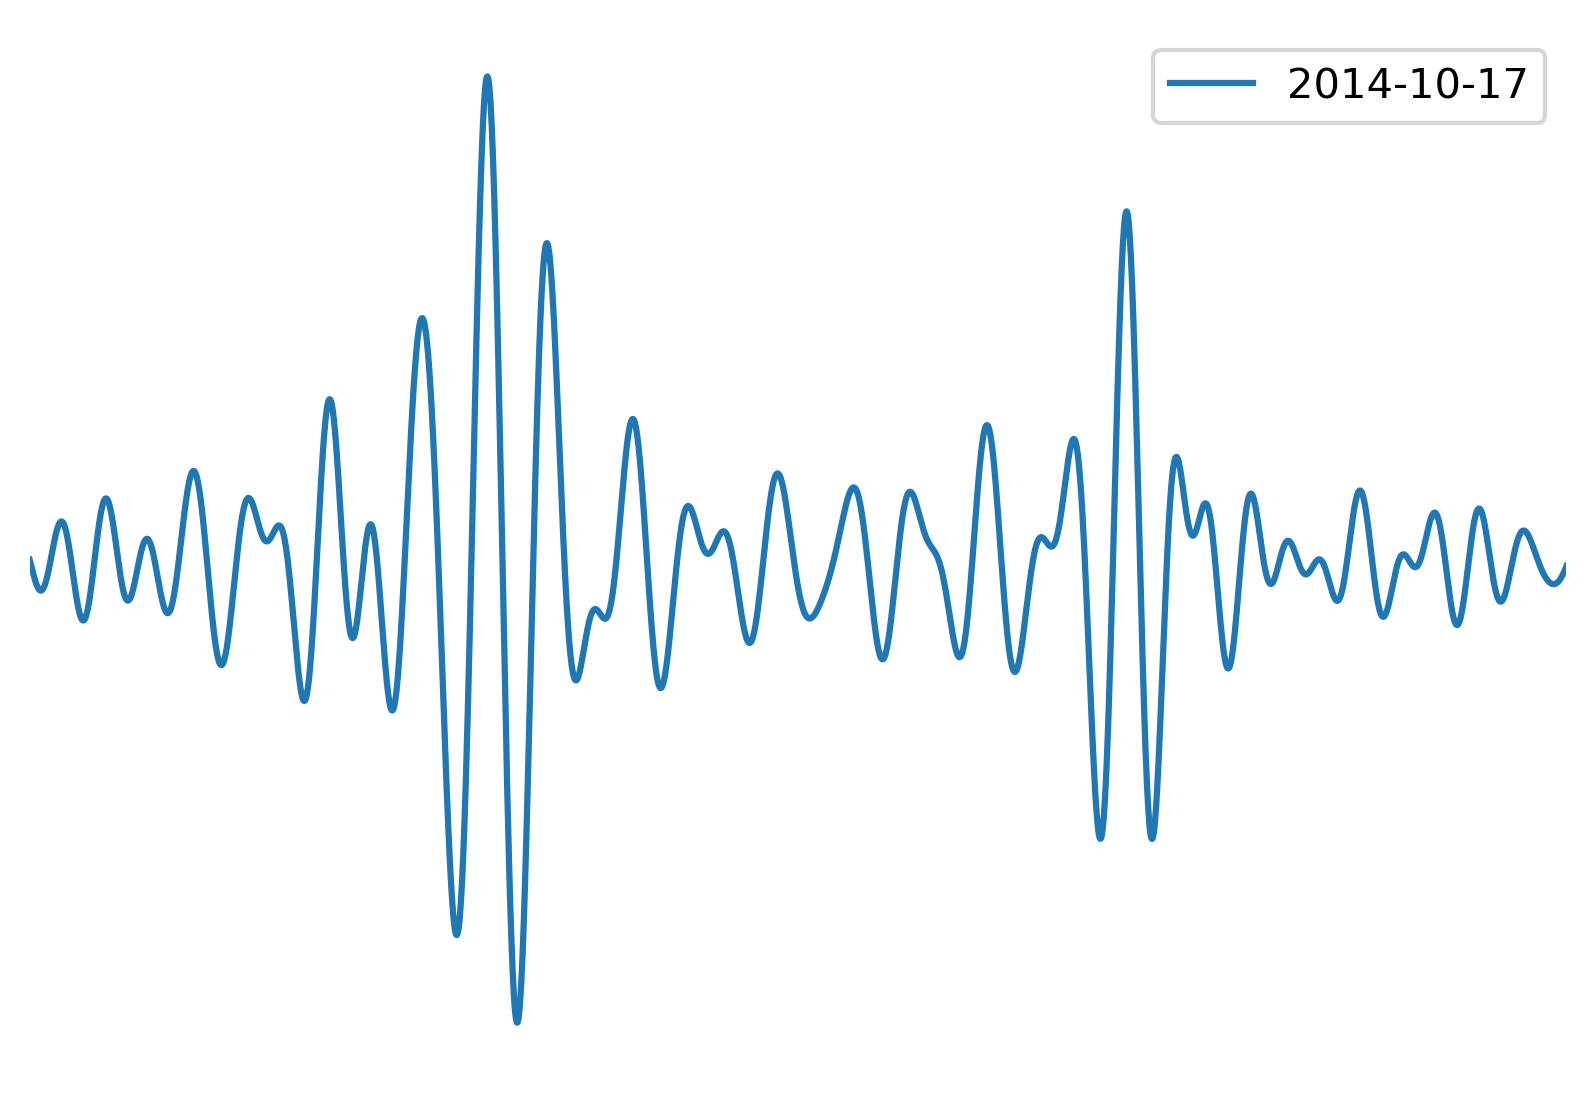

In [71]:
from ocloc import read_correlation_file
corr = correlation_obj # Shorter name.
corr2 = correlation_obj2 # Shorter name.
min_t = -50 # Min t in [s] for plotting
max_t = 50 # Max t in [s] for plotting
observed_shift = corr.t_app[-1] # in [s]

# Load the correlation file as obspy.Trace object
# (with some additional attributes)
tr1 = read_correlation_file(corr.file_path)
tr2 = read_correlation_file(corr2.file_path)

for tr in [tr1, tr2]:
    tr = tr.filter(
        "bandpass",
        freqmin=cd.processing_parameters[0].freqmin,
        freqmax=cd.processing_parameters[0].freqmax,
        corners=4,
        zerophase=True)

# Define the t=0 as the middle of the cross-correlation.
start = -tr.times()[-1] / 2.0
end = tr.times()[-1] / 2.0

# Define our time vector.
t = np.linspace(start, end, tr.stats.npts)

# Define our amplitudes-vector
data1 = tr1.data
data2 = tr2.data

# Make figure.
figure = plt.figure(dpi=300)
plt.plot(t, data1, label=str(tr1.stats.average_date)[:10])
#plt.plot(t, data2, label=str(tr2.stats.average_date)[:10], ls="--",color="C1")

plt.xlim(min_t, max_t)
plt.ylabel("Amplitudes")
plt.tight_layout()
plt.legend(loc="best")
plt.axis('off')
plt.savefig("/Users/localadmin/Downloads/last.png")
plt.show()

To understand the process behind the Fortran routines let's explain is step by step. The procedure goes like this:
    
   1. The algorithm chooses a time window based on the apriori estimate as well as a reference surface wave velocity. Then, the program computes the peak and trough envelope of the signal within the selected time window. The two points where the difference between both envelopes is at their maximum provide an estimate of the occurrence of the causal and acausal surface waves.

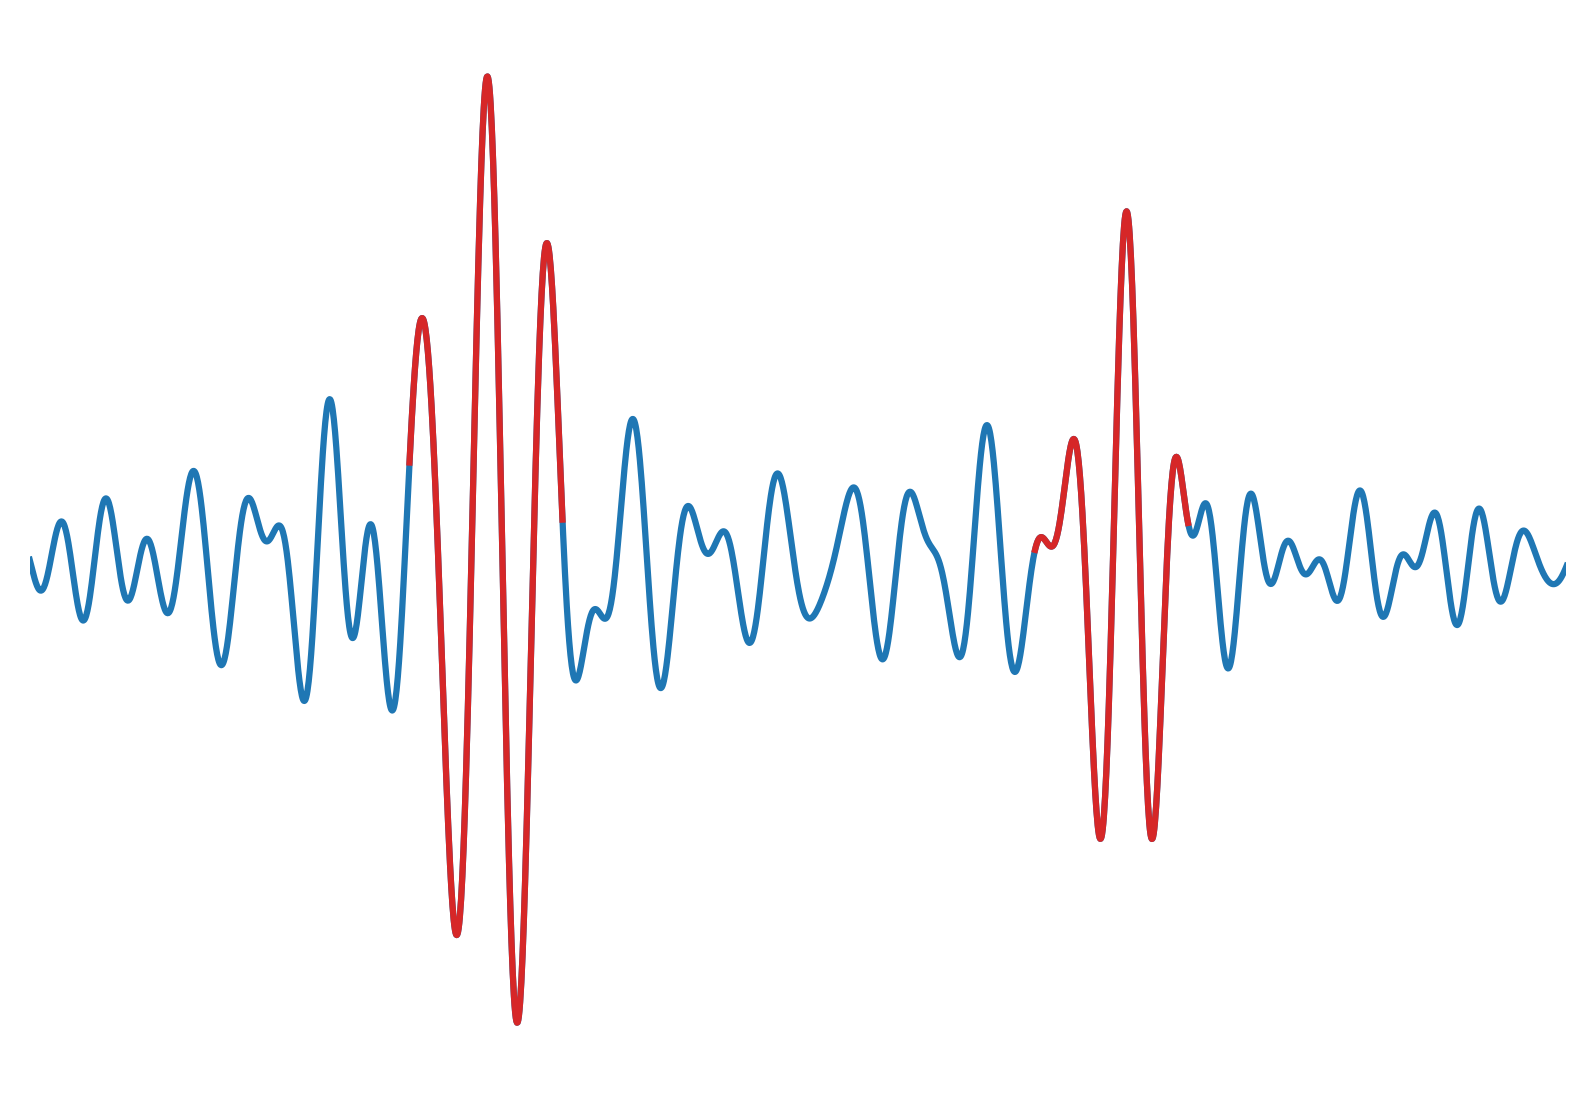

In [73]:
from ocloc import read_correlation_file
corr = correlation_obj # Shorter name.
min_t = -50 # Min t in [s] for plotting
max_t = 50 # Max t in [s] for plotting
observed_shift = corr.t_app[-1] # in [s]

# Index of start and end of acausal signal
ac_i0 = int(corr.acausal_from_index)
ac_if = int(corr.acausal_until_index)

# Index of start and end of causal signal
c_i0, cif = int(corr.causal_from_index), int(corr.causal_until_index)

# Load the correlation file as obspy.Trace object
# (with some additional attributes)
tr = read_correlation_file(corr.file_path)
tr = tr.filter(
    "bandpass",
    freqmin=cd.processing_parameters[0].freqmin,
    freqmax=cd.processing_parameters[0].freqmax,
    corners=4,
    zerophase=True)

# Define the t=0 as the middle of the cross-correlation.
start = -tr.times()[-1] / 2.0
end = tr.times()[-1] / 2.0

# Define our time vector.
t = np.linspace(start, end, tr.stats.npts)

# Define our amplitudes-vector
data = tr.data

# Make figure.
figure = plt.figure(dpi=300)
plt.plot(t, data, label=str(tr.stats.average_date)[:10])
plt.plot(t[ac_i0:ac_if], data[ac_i0:ac_if], color="C3")
plt.plot(
    t[c_i0:cif],
    data[c_i0:cif],
    label="Estimated causal and acausal wave",
    color="C3")

plt.xlim(min_t, max_t)
plt.ylabel("Amplitudes")
plt.tight_layout()
#plt.legend(loc="best")
plt.axis('off')
plt.savefig("/Users/localadmin/Downloads/causal-acausal.png")
plt.show()

   2. The signal of the causal and acausal waves are retrieved from a window of length $1/f_c$ centered around the causal and acausal waves.

   3. The envelopes of the causal and acausal are calculated. The time when the difference between the top and bottom envelope is maximum is reffered to as $t_{est}$

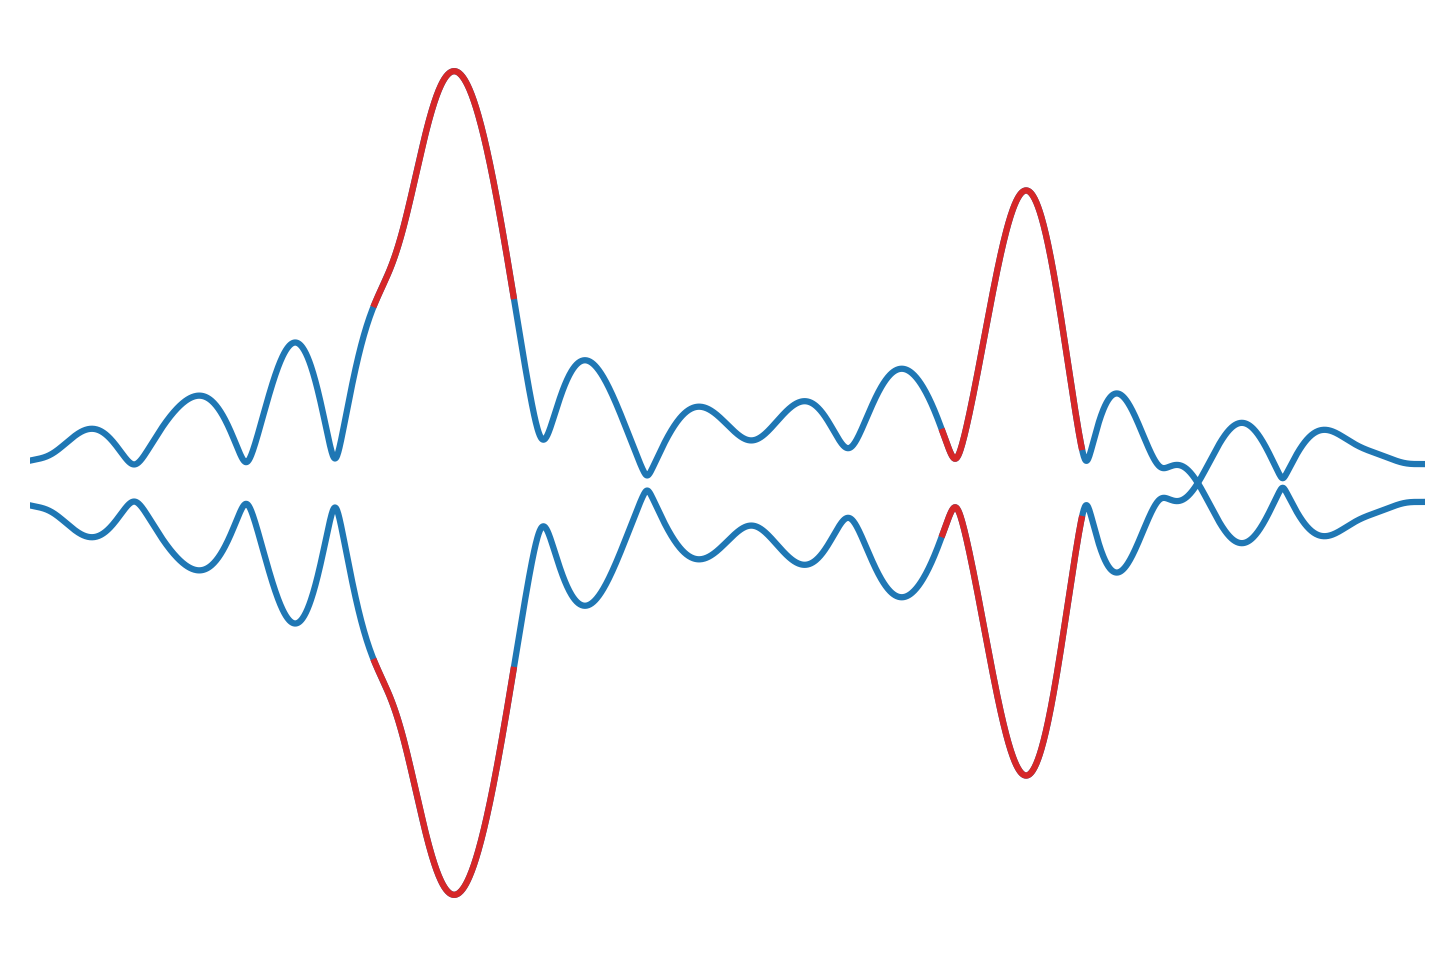

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

analytic_signal = hilbert(data)
amplitude_envelope = np.abs(analytic_signal)
figure = plt.figure(dpi=300)
#plt.plot(t, data, label=str(tr.stats.average_date)[:10],
# color="C0")
plt.plot(t, amplitude_envelope, label="Signal's envelope", color="C0")
plt.plot(t, -amplitude_envelope, color="C0")
plt.plot(t[ac_i0:ac_if], amplitude_envelope[ac_i0:ac_if], color="C3")
plt.plot(t[ac_i0:ac_if], -amplitude_envelope[ac_i0:ac_if], color="C3")
plt.plot(
    t[c_i0:cif],
    amplitude_envelope[c_i0:cif],
    label="Estimated causal and acausal wave",
    color="C3")
plt.plot(
    t[c_i0:cif],
    -amplitude_envelope[c_i0:cif],
    color="C3")
plt.xlim(min_t, max_t)
plt.axis('off')
#plt.legend(loc="best")
plt.savefig("/Users/localadmin/Downloads/envelopes.png")


   3. Then, one of the time windows is correlated with the time-reversed signal of the other time window. We only use a time window with a length of about one period centered around the $t_{est}$. The time lag to maximum waveform similarity equals twice the sum of the instrumental incurred errors of station i and station j. The result is called in our paper: $2\delta t_{(ins,app)} + 2\delta t_{(ins,app)}$. Therefore, adding the time lag provides the sought for value of:

$$\delta t_{(+,app)} + \delta t_{(−,app)}$$

If we now plot the result and the reversed time signal we should see that the interferometric responses overlay each other:

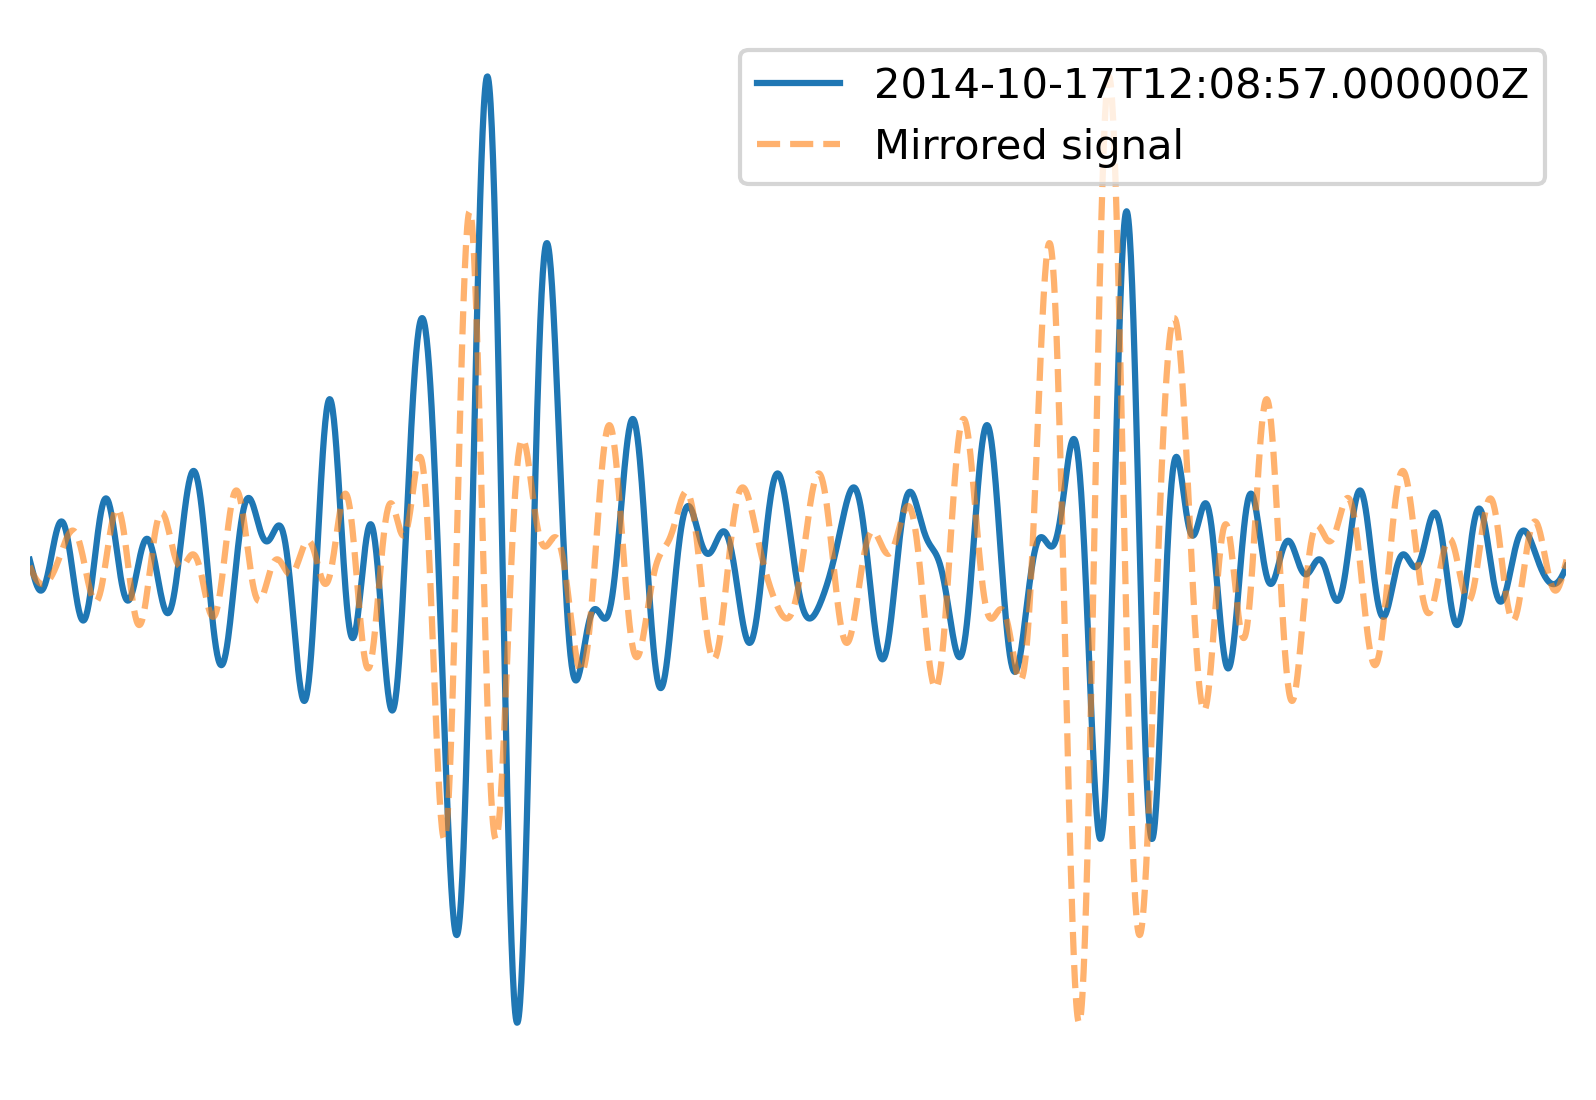

In [81]:
figure = plt.figure(dpi=300)
plt.plot(t, data, label=tr.stats.average_date)
plt.plot(t, data[::-1], ls="--", label="Mirrored signal", alpha=0.6)
plt.xlim(min_t, max_t)
plt.ylabel("Amplitudes")
plt.tight_layout()
plt.legend(loc="best")
plt.axis('off')
plt.savefig("/Users/localadmin/Downloads/mirrored2.png")
plt.show()

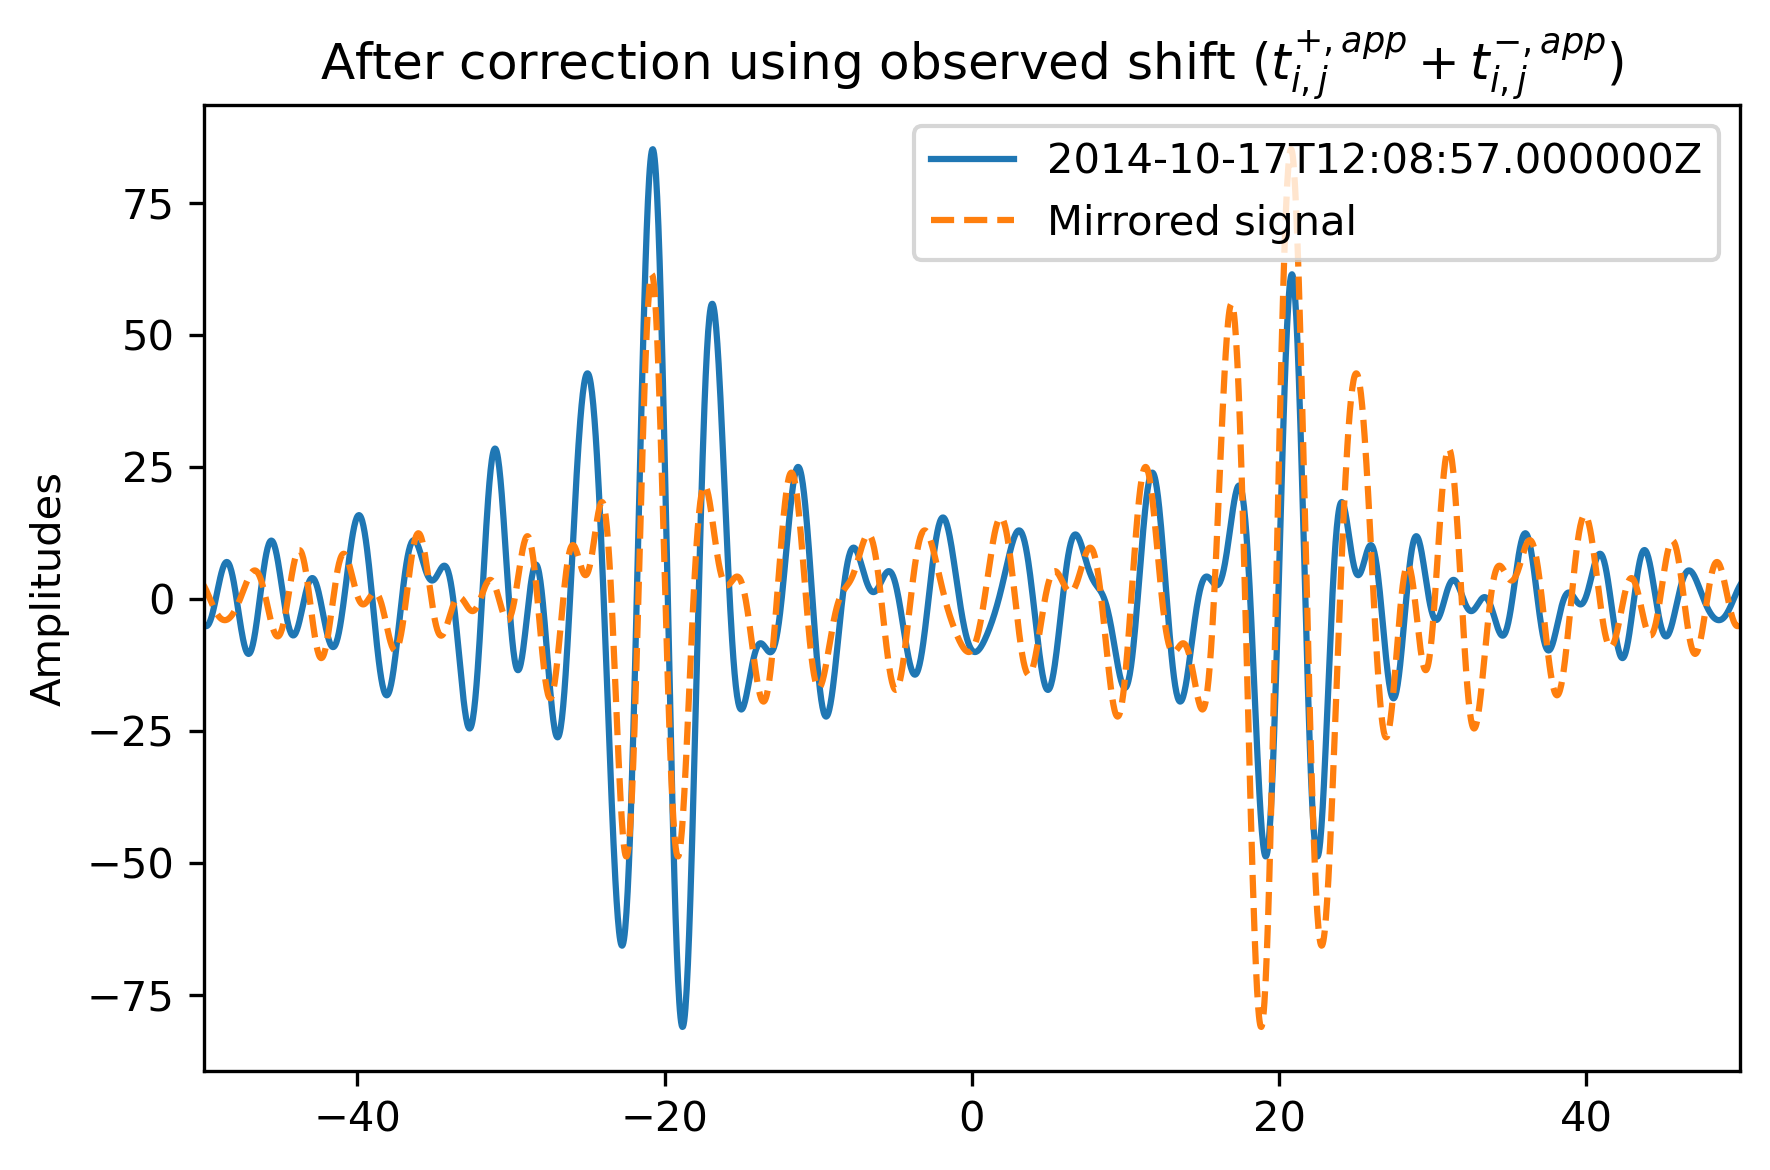

In [40]:
figure = plt.figure(dpi=300)
plt.plot(t - observed_shift / 2, data, label=tr.stats.average_date)
plt.plot(t + observed_shift / 2, data[::-1], ls="--", label="Mirrored signal")
plt.title(
    "After correction using observed shift ($t^{+, app}_{i, j}"
    + " + t^{-, app}_{i, j}$)")
plt.xlim(min_t, max_t)
plt.ylabel("Amplitudes")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## 4.3 Calculate $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ for all correlation pairs simultaneously

To calculate the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ for all cross-correlations just do:

In [41]:
cd.calculate_tapp_4_allcorrelations()

Calculating the t_app for each stationpair.
